# Assignment 2 : Completing the test 

## Idea

### Younger persons tend to ride bikes longer than older persons

$H_0$ : ${\mu_{\mathrm{{[25 or younger:tripduration]}}}} <= {\mu_{\mathrm{[older than 25:tripduration]}}}$

$H_a$ : ${\mu_{\mathrm{{[25 or younger:tripduration]}}}} > {\mu_{\mathrm{[older than 25:tripduration]}}}$

## Null hypothesis

### The average trip duration for a month for persons from age group < 25 years is less than or same as the average trip duration for persons > 25 years of age


We download the CitiBike data for testing the idea

In [91]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

%pylab inline

if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIdata")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUIdata")

import os
import json
#s = json.load( open(os.getenv('PUI2016') + "/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)

np.random.seed(2002)

Populating the interactive namespace from numpy and matplotlib


In [30]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

### Acquiring the bike data for 10/2016 and moving it to PUIdata directory

In [31]:
datestring = '201610'
getCitiBikeCSV(datestring)

file in place, you can continue


In [35]:
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')

In [36]:
df.shape

(1573872, 15)

In [37]:
df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,328,2016-10-01 00:00:07,2016-10-01 00:05:35,471,Grand St & Havemeyer St,40.712868,-73.956981,3077,Stagg St & Union Ave,40.708771,-73.950953,25254,Subscriber,1992.0,1
1,398,2016-10-01 00:00:11,2016-10-01 00:06:49,3147,E 85 St & 3 Ave,40.778012,-73.954071,3140,1 Ave & E 78 St,40.771404,-73.953517,17810,Subscriber,1988.0,2
2,430,2016-10-01 00:00:14,2016-10-01 00:07:25,345,W 13 St & 6 Ave,40.736494,-73.997044,470,W 20 St & 8 Ave,40.743453,-74.000040,20940,Subscriber,1965.0,1
3,351,2016-10-01 00:00:21,2016-10-01 00:06:12,3307,West End Ave & W 94 St,40.794165,-73.974124,3357,W 106 St & Amsterdam Ave,40.800836,-73.966449,19086,Subscriber,1993.0,1
4,2693,2016-10-01 00:00:21,2016-10-01 00:45:15,3428,8 Ave & W 16 St,40.740983,-74.001702,3323,W 106 St & Central Park West,40.798186,-73.960591,26502,Subscriber,1991.0,1


In [38]:
df.columns

Index([u'Trip Duration', u'Start Time', u'Stop Time', u'Start Station ID',
       u'Start Station Name', u'Start Station Latitude',
       u'Start Station Longitude', u'End Station ID', u'End Station Name',
       u'End Station Latitude', u'End Station Longitude', u'Bike ID',
       u'User Type', u'Birth Year', u'Gender'],
      dtype='object')

### Keeping the columns that will be used to test our hypothesis. Only trip duration, birth year and gender are relevant for this


In [39]:
df.drop(['Start Time', 'Stop Time', 'Start Station ID',
       'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station ID', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'Bike ID', 'User Type'], axis=1, inplace=True)

In [40]:
df.head()

,Trip Duration,Birth Year,Gender
0,328,1992.0,1
1,398,1988.0,2
2,430,1965.0,1
3,351,1993.0,1
4,2693,1991.0,1


In [41]:
print(max(df['Trip Duration']))

8933552


In [10]:
len(df)

1573872

### Dropping all the rows with empty fields in one or more columns


In [42]:
df = df.dropna()
len(df)

1406424

### Taking the observations with the birth year >1966 (people younger than 50 years of age)


In [43]:
df = df[df['Birth Year'] > 1966]
len(df)

1153343

In [44]:
df0 = df[df['Birth Year'] > 1991]
df1 = df[df['Birth Year'] < 1991]

In [45]:
print(len(df0), len(df1))

132726 973270


In [17]:
df0.head()

,Trip Duration,Birth Year,Gender
0,328,1992.0,1
3,351,1993.0,1
5,513,1995.0,1
9,269,1993.0,2
22,755,1996.0,1


### Removing the extreme values which are not practical of trip durations from the data

In [46]:
df0 = df0[(df0['Trip Duration']<18000)]
df1 = df1[(df1['Trip Duration']<18000)]

## Plotting the whole data for visualising

In [69]:
df2 = df0.append(df1)

In [75]:
df2.head()

,Trip Duration,Birth Year,Gender
0,328,1992.0,1
3,351,1993.0,1
5,513,1995.0,1
9,269,1993.0,2
22,755,1996.0,1


[]

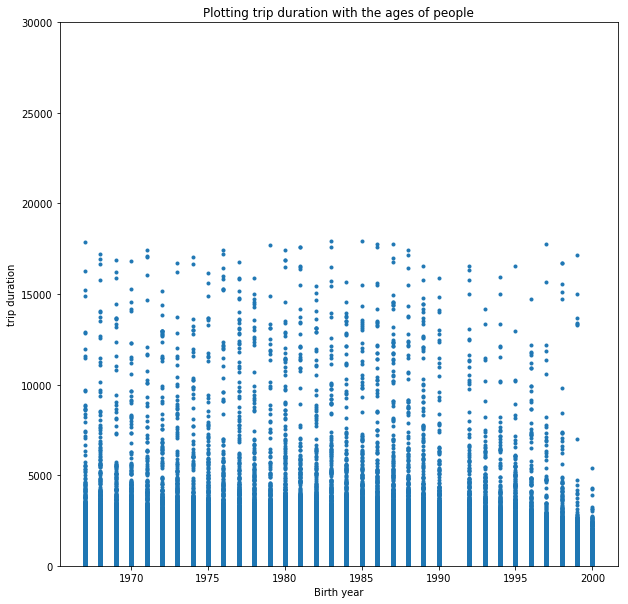

In [104]:
plt.figure(figsize=(10,10))
plt.plot(df2['Birth Year'], df2['Trip Duration'], '.')
plt.ylim(0, 30000)
plt.xlabel('Birth year')
plt.ylabel('trip duration')
plt.title('Plotting trip duration with the ages of people')
plt.plot()

In [62]:
trips1 = df0['Trip Duration'].values
print(trips1)
print(trips1.sum()/len(trips1))

[ 328  351  513 ..., 1716 1463 1889]
729.136518514


In [81]:
len(df0)

132656

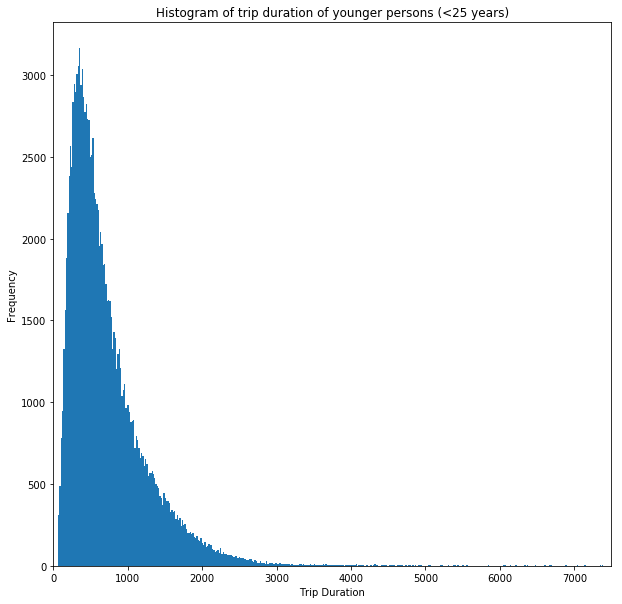

In [102]:
plt.figure(figsize=(10,10))
plt.hist(df0['Trip Duration'], bins=1000)
plt.xlim(0,7500)
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Histogram of trip duration of younger persons (<25 years)')

In [108]:
print('Mean of young age group trip duration:', df0['Trip Duration'].sum()/len(df0))

Mean of young age group trip duration: 729.136518514


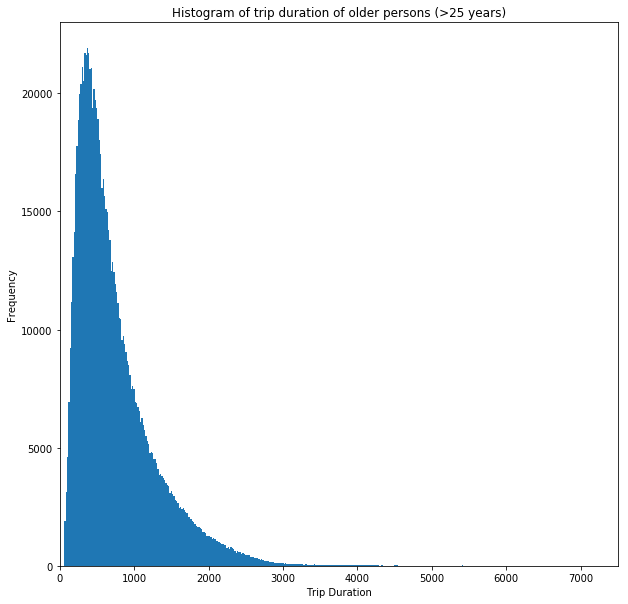

In [103]:
plt.figure(figsize=(10,10))
plt.hist(df1['Trip Duration'], bins=1000)
plt.xlim(0,7500)
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Histogram of trip duration of older persons (>25 years)')

In [106]:
print('Mean of old age group trip duration:', df1['Trip Duration'].sum()/len(df1))

Mean of old age group trip duration: 751.582487934


## Welch's t-test

In [97]:
stats.ttest_ind(df1['Trip Duration'].values, df0['Trip Duration'].values, equal_var=False)

Ttest_indResult(statistic=12.507329800214857, pvalue=7.0584133715259319e-36)

### Since the p value is very low, we can easily reject the hypothesis that the two distributions are statistically same. But, on comparing the means of the trip durations of two age groups, we find that the average trip duration of young persons is actually less than that from older persons. Thus our original hypothesis which claims that young persons ride for longer duration should be rejected because we found that the older people tend to ride longer.